In [2]:
# Import tfidf and normalizer for bag of words and pre-processing
# Import LDA, K-means clustering, NMF, and LSA 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score

# Import general use tools
from collections import defaultdict
from tqdm import tqdm_notebook
import pandas as pd
import numpy as np
import time

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly
import random

import warnings 
warnings.filterwarnings('ignore')

In [3]:
# Import stop_words and create list to hold additions
from sklearn.feature_extraction import text 

my_additional_stop_words=['15','2628','446','2607','419''____','petition','supreme','rehearing','sugg','plaintiff',
                          'error','employés', '000','ch','said','company','united', 'federal', 'district', 'right',
                          'id', 'opinion','law', 'case', 'state', 'court','sentence','petitioner','pub','280','ch',
                          'statute','case','ct', 'mr', 'ถถ', 'งง', 'zzz','supra','infra','appellant','appellee', 'id',
                          '413', '93', '37','1973','act', 'make', 'ante', 'cite', 'claim', 'respondent','rule','shall',
                          'judgment','say', 'ed', '2d', 'ct','rev','sup','rep','new york','york']

# Update the in-built stopwords list
stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

In [4]:
df = pd.read_csv('Corpora/14th_cleaned_corpora.csv')

In [5]:
df.sort_values(by="year", inplace=True)

In [6]:
# one missing year
df.at[1807, 'year'] = 2019

In [7]:
df.resource_uri.iloc[977]

'https://www.courtlistener.com:80/api/rest/v3/clusters/99548/'

### Create a Bag of Words with TF-IDF

Get columns required for analysis

In [8]:
cols = ['id_x', 'year', 'case_name', 'corpora']

In [9]:
corp = df[cols].copy()

In [10]:
corp

,id_x,year,case_name,corpora
1523,88200,1870.0,Worthy v. Commissioners,wall worthyvthe commissionerssupreme court uni...
1789,88503,1872.0,Osborn v. Nicholson,wall osbornvnicholson et alsupreme court unite...
3851,88662,1873.0,Bradwell v. State,wall bradwellvthe statesupreme court united st...
725,88661,1873.0,Slaughter-House Cases,wall slaughter-house casesthe butcher benevole...
250,88800,1874.0,Bartemeyer v. Iowa,wall bartemeyerviowasupreme court united state...
2508,88998,1875.0,Minor v. Happersett,wall minorvhappersettsupreme court united stat...
1045,89115,1875.0,Scholey v. Rew,wall scholeyvrewsupreme court united state mr ...
3904,89233,1876.0,Raymond v. Thomas,raymondvthomassupreme court united statesmr p ...
4491,89245,1876.0,Walker v. Sauvinet,walkervsauvinetsupreme court united state mr c...
422,89266,1876.0,United States v. REESE,united statesvreese et alsupreme court united ...


In [11]:
# fit method creates bag of words. See them with .get_feature_names()
# This returns a sparse matrix. For a dense matrix, you could perform:
# pd.DataFrame(dtm.toarray(), columns=vect.get_feature_names())

# Create a bag of words using ngrams up to 3 words long

vect = CountVectorizer(ngram_range=(1,3))

In [ ]:
def make_bow(df_col):
    #custom_vec = CountVectorizer(ngram_range=(1,3))
    custom_vec = CountVectorizer(strip_accents="unicode", stop_words)
    corpora = df_col.values.flatten().tolist()
    wm = custom_vec.fit_transform(corpora)
    vocab = custom_vec.vocabulary_
    tokens = custom_vec.get_feature_names()
    #df = wm_to_df(wm, tokens)
    
    return wm, tokens, vocab #df, tokens
# Create the matrix and get the features and vocab on the whole corpus
wordmatrix, features, vocab = make_bow(corp['corpora'])

In [14]:
# Create a dataframe of bag of words vocabulary
def bow_df(vocab):
    vocab_values = list(vocab.values())
    vocab_keys = list(vocab.keys())
    count_df = pd.DataFrame(list(zip(vocab_keys,vocab_values)))
    count_df.columns = ['Word', 'Count']
    count_df.sort_values(by='Count', ascending=False, inplace=True)
    return count_df

# count_df = bow_df(vocab)

## Perform Latent Semantic Analysis on the corpus as a whole

In [15]:
# Create a pipeline to perform LSA
# Create a vectorizer to convert raw documents to TF/IDF matrix
vectorizer = TfidfVectorizer(stop_words=stop_words,
                             strip_accents="unicode",
                             ngram_range=(1,2),
                             use_idf=True, 
                             smooth_idf=True)

# This normalizes the vector (L2 norm of 1.0) to neutralize 
# the effect of document length on tf-idf.

normalizer = Normalizer(copy=False)

# Perform singular value decomposition:
# Project the tfidf vectors onto the first N principal components.

svd_model = TruncatedSVD(n_components=100,         # number of dimensions
                         algorithm='randomized',
                         n_iter=10)

lsa_transformer = Pipeline([('tfidf', vectorizer), 
                            ('svd', svd_model),
                            ('norm', normalizer)])

In [16]:
def lsa_transform(corpora):
    lsa_matrix = lsa_transformer.fit_transform(corpora)
    print(f"tf-idf params: {lsa_transformer.steps[0][1].get_params()}")

    # Get the words that correspond to each of the features.
    feat_names = lsa_transformer.steps[0][1].get_feature_names()
    vocab = lsa_transformer.steps[0][1].vocabulary_
    
    return lsa_matrix, feat_names, vocab

# lsa_matrix, feat_names, lsa_vocab = lsa_transform(corp['corpora'])

In [ ]:
# Plot the top 10 terms for each top-10 LSA component. 
for component_num in range(0, 10): # i.e., the top 10 components.

    comp = lsa_transformer.steps[1][1].components_[component_num]
    
    # Sort the weights in the first component and get indices
    indices = np.argsort(comp).tolist()
    
    # Reverse order (largest weights first)
    indices.reverse()
    
    # Get top 10 terms for each component        
    terms = [feat_names[weight_index] for weight_index in indices[0:10]]    
    weights = [comp[weight_index] for weight_index in indices[0:10]]    
   
    # Display these terms and their weights as a horizontal bar graph.    
    # The horizontal bar graph displays the first item on the bottom; reverse
    # the order of the terms so the biggest one is on top.
    terms.reverse()
    weights.reverse()
    positions = np.arange(10) + .5    # Center the bar on the y axis.
    
    plt.figure(component_num)
    plt.barh(positions, weights, align="center")
    plt.yticks(positions, terms)
    plt.xlabel("Weight")
    plt.title(f"Strongest terms for component {component_num+1}")
    plt.grid(True)
    plt.savefig(f"terms_for_component_{component_num+1}")
    plt.show()

## Rolling window topic modeling

In [179]:
# Create year ranges and bin the data accordingly.
# To track evolution over time, the cases will be binned
# in a rolling fashion, with overlap, to smooth out
# the effects of the groupings. 

# ------------------------

# Include left, exclude right; half-closed, half-open interval [a, b)
# cf. pandas rolling() function

def build_year_ranges(overlap, first=1785, last=2019, increment=20):
    # assert: bin cannot be underfull; overlap shouldn't exceed smallest bin size. 
    # max increment // 2 is a guideline. 
    # rewrite this as a class.
    # overlap = max(overlap, increment // 2)
    year_ranges = []
    for n in range(first, last, overlap):
        year_ranges.append((n, n + increment))
    return year_ranges

# warning: years must have the same index as data
def put_data_under_year_ranges(data, years, year_ranges):

    # assert len(data) == len(years), \
    # "get_content_under_ranges: data and years do not match length"

    # build a dict with keys = year_ranges, with a list for each range
    data_ranges = defaultdict(list)
    
    # bin all the data by range - each row should fall in two bins, 
    # if ranges are cleanly overlapped

    # if data is a list
    for i in range(len(data)):
        for y in year_ranges:
            if y[0] <= years[i] and years[i] < y[1]:
                data_ranges[y].append(data[i]) # for dictionary
                
                # this should happen twice for every entry except 
                # the very oldest and the very newest
    return data_ranges
# ------------
# main
              
# bins = build_year_ranges(first_year, last_year, increment, overlap)
# binned_data = put_data_under_year_ranges(cases, years, bins)

In [160]:
# Convert DataFrame columns to lists (warning: keep indices aligned, 
# and make sure cases are sorted by year)

corp_list = corp["corpora"].values.flatten().tolist()
year_list = corp["year"].values.flatten().tolist()
names_list = corp["case_name"].values.flatten().tolist()

In [161]:
# Create a numpy array for all cases 
# in the format array[name][text]

case_dict = np.array(list(zip(names_list, corp_list)))

# Get all case texts: case_dict[:,1]
# Get all case names: case_dict[:,0]
type(case_dict[:,1][0])

numpy.str_

In [192]:
year_ranges = build_year_ranges(overlap=10, first=1860, last=2019, increment=10)
# binned_data = put_data_under_year_ranges(corp_list, year_list, year_ranges) # dict of lists
binned_data = put_data_under_year_ranges(case_dict, year_list, year_ranges) # dict of arrays

In [193]:
years_k = list(binned_data.keys())
values_v = [len(v) for v in binned_data.values()]
num_cases = list(zip(years_k, values_v))

In [194]:
for k,v in binned_data.items():
    print(f"Number of cases decided circa {k}: {len(v)}")

Number of cases decided circa (1870, 1880): 18
Number of cases decided circa (1880, 1890): 62
Number of cases decided circa (1890, 1900): 164
Number of cases decided circa (1900, 1910): 296
Number of cases decided circa (1910, 1920): 414
Number of cases decided circa (1920, 1930): 357
Number of cases decided circa (1930, 1940): 291
Number of cases decided circa (1940, 1950): 246
Number of cases decided circa (1950, 1960): 197
Number of cases decided circa (1960, 1970): 405
Number of cases decided circa (1970, 1980): 765
Number of cases decided circa (1980, 1990): 734
Number of cases decided circa (1990, 2000): 299
Number of cases decided circa (2000, 2010): 181
Number of cases decided circa (2010, 2020): 150


In [195]:
# Use a dictionary comprehension to convert a list of lists
# to a numpy array for easier access to values

binned_data = {k: np.asarray(v) for k,v in binned_data.items()}

In [196]:
num_df = pd.DataFrame(num_cases)
num_df.columns = ["Years", "Approx. No. Opinions Issued"]
num_df.Years = num_df.Years.apply(lambda x: (x[0]+x[1])/2)
fig = px.bar(num_df, x='Years', y='Approx. No. Opinions Issued')
fig.show()

In [197]:
# rewrite to use only binned_data keys
# need an assert statement to handle edge cases of too-small buckets
# make rolling a class

def LSA_per_bin(corpora, ngrams=(1,2)):

    vectorizer = TfidfVectorizer(stop_words=stop_words,
                             strip_accents="unicode",
                             ngram_range=ngrams,
                             use_idf=True, 
                             smooth_idf=True)

    normalizer = Normalizer(copy=False)
    svd_model = TruncatedSVD(n_components=100,         
                         algorithm='randomized',
                         n_iter=10)

    lsa_transformer = Pipeline([('tfidf', vectorizer), 
                                ('svd', svd_model),
                                ('norm', normalizer)])
    
    # assert: first pipeline component must be tfidf/count vectorizer
    lsa_matrix = lsa_transformer.fit_transform(corpora)

    # Get the words that correspond to each of the features.
    feat_names = lsa_transformer.steps[0][1].get_feature_names()
    vocab = lsa_transformer.steps[0][1].vocabulary_

    
    ceiling = min(len(corpora), 10)
    for component_num in range(0, ceiling):
    
        comp = lsa_transformer.steps[1][1].components_[component_num]
        
        # Sort the weights in the first component and get indices
        indices = np.argsort(comp).tolist()
        
        # Reverse order (largest weights first)
        indices.reverse()
        
        # Get top 10 terms for component        
        terms = [feat_names[weight_index] for weight_index in indices[0:ceiling]]    
        weights = [comp[weight_index] for weight_index in indices[0:ceiling]] 
        terms.reverse()
        weights.reverse()
        
        bin_terms = terms
        bin_weights = weights
        bin_matrix = lsa_matrix
        bin_feat_names = feat_names
        bin_vocab = vocab
        
    return {"terms": bin_terms, "weights": bin_weights, "matrix": bin_matrix, 
            "feat_names": bin_feat_names, "vocab": bin_vocab}
        
def rolling_LSA(binned_data):    # (binned_data, year_ranges)
    
    model_ranges = defaultdict(dict)
    #for y in year_ranges:
    #    model_ranges[y] = []
    
    for y in tqdm_notebook(binned_data.keys()): # keys must be year ranges
        model_ranges[y] = LSA_per_bin(binned_data[y][:,1]) # [:,1] needed only if binned_data is np.array. 
                                                           # use .append() instead of = if model_ranges is dict 
                                                           # as opposed to defaultdict
        print(f"Running cases from: {y}") 
        
    return model_ranges    

In [ ]:
lsa = rolling_LSA(binned_data)

Running cases from: (1870, 1880)
Running cases from: (1880, 1890)
Running cases from: (1890, 1900)
Running cases from: (1900, 1910)
Running cases from: (1910, 1920)
Running cases from: (1920, 1930)
Running cases from: (1930, 1940)
Running cases from: (1940, 1950)
Running cases from: (1950, 1960)
Running cases from: (1960, 1970)
Running cases from: (1970, 1980)


In [43]:
for k,v in lsa.items():
    print(f"Top terms for {k}:\n{lsa[k]['terms']}") 
          
# N.B.: Proper indexing is lsa[k][0]['terms'] if model_ranges is dict rather than defaultdict

Top terms for (1865, 1875):
['government', 'corporation', 'exclusive', 'citizen', 'privilege']
Top terms for (1870, 1880):
['ship vessel', 'water', 'trial', 'regulate', 'cabin', 'steamer', 'coast', 'vessel', 'commerce', 'passenger']
Top terms for (1875, 1885):
['jurisdiction', 'objection', 'grand', 'indictment', 'grand jury', 'laundry', 'section', 'person', 'city county', 'offense']
Top terms for (1880, 1890):
['expense', 'corporation', 'bank', 'tax', 'race', 'assessment', 'drainage', 'owner', 'vroom', 'land']
Top terms for (1885, 1895):
['munn illinois', 'railroad', 'store', 'warehouse', 'public', 'munn', 'illinois', 'business', 'elevator', 'grain']
Top terms for (1890, 1900):
['year', 'born', 'nebraska', 'race', 'collar', 'kill dog', 'citizen', 'kill', 'rate', 'dog']
Top terms for (1895, 1905):
['debt', 'mortgagee', 'corporation', 'asset', 'dog', 'resident', 'citizen', 'mortgage', 'tennessee', 'creditor']
Top terms for (1900, 1910):
['tax', 'tax deed', 'health', 'commission', 'title'

Optimal # of clusters for whole 14th corpus?

Init 1/1 with method: k-means++
Inertia for init 1/1: 481.676350
Minibatch iteration 1/46000: mean batch inertia: 0.972625, ewa inertia: 0.972625 
Minibatch iteration 2/46000: mean batch inertia: 0.976482, ewa inertia: 0.972794 
Minibatch iteration 3/46000: mean batch inertia: 0.969242, ewa inertia: 0.972639 
Minibatch iteration 4/46000: mean batch inertia: 0.970371, ewa inertia: 0.972540 
Minibatch iteration 5/46000: mean batch inertia: 0.969884, ewa inertia: 0.972424 
Minibatch iteration 6/46000: mean batch inertia: 0.971574, ewa inertia: 0.972387 
Minibatch iteration 7/46000: mean batch inertia: 0.969679, ewa inertia: 0.972268 
Minibatch iteration 8/46000: mean batch inertia: 0.966951, ewa inertia: 0.972036 
Minibatch iteration 9/46000: mean batch inertia: 0.970539, ewa inertia: 0.971971 
Minibatch iteration 10/46000: mean batch inertia: 0.970701, ewa inertia: 0.971915 
Minibatch iteration 11/46000: mean batch inertia: 0.968200, ewa inertia: 0.971753 
Minibatch iteration 12/46000: m

Minibatch iteration 54/46000: mean batch inertia: 0.965134, ewa inertia: 0.964872 
Minibatch iteration 55/46000: mean batch inertia: 0.961201, ewa inertia: 0.964712 
Minibatch iteration 56/46000: mean batch inertia: 0.961424, ewa inertia: 0.964568 
Minibatch iteration 57/46000: mean batch inertia: 0.964652, ewa inertia: 0.964572 
Minibatch iteration 58/46000: mean batch inertia: 0.961589, ewa inertia: 0.964442 
Minibatch iteration 59/46000: mean batch inertia: 0.967540, ewa inertia: 0.964577 
Minibatch iteration 60/46000: mean batch inertia: 0.958141, ewa inertia: 0.964296 
Minibatch iteration 61/46000: mean batch inertia: 0.964763, ewa inertia: 0.964316 
Minibatch iteration 62/46000: mean batch inertia: 0.959446, ewa inertia: 0.964104 
Minibatch iteration 63/46000: mean batch inertia: 0.960292, ewa inertia: 0.963937 
Minibatch iteration 64/46000: mean batch inertia: 0.960912, ewa inertia: 0.963805 
Minibatch iteration 65/46000: mean batch inertia: 0.960959, ewa inertia: 0.963681 
Mini

Minibatch iteration 54/46000: mean batch inertia: 0.956046, ewa inertia: 0.960079 
Minibatch iteration 55/46000: mean batch inertia: 0.957712, ewa inertia: 0.959976 
Minibatch iteration 56/46000: mean batch inertia: 0.955892, ewa inertia: 0.959798 
Minibatch iteration 57/46000: mean batch inertia: 0.957895, ewa inertia: 0.959714 
Minibatch iteration 58/46000: mean batch inertia: 0.954746, ewa inertia: 0.959497 
Minibatch iteration 59/46000: mean batch inertia: 0.962682, ewa inertia: 0.959637 
Minibatch iteration 60/46000: mean batch inertia: 0.954606, ewa inertia: 0.959417 
Minibatch iteration 61/46000: mean batch inertia: 0.957690, ewa inertia: 0.959341 
Minibatch iteration 62/46000: mean batch inertia: 0.954958, ewa inertia: 0.959150 
Minibatch iteration 63/46000: mean batch inertia: 0.955365, ewa inertia: 0.958985 
Minibatch iteration 64/46000: mean batch inertia: 0.954529, ewa inertia: 0.958790 
Minibatch iteration 65/46000: mean batch inertia: 0.956565, ewa inertia: 0.958693 
Mini

Minibatch iteration 33/46000: mean batch inertia: 0.961041, ewa inertia: 0.961605 
Minibatch iteration 34/46000: mean batch inertia: 0.960300, ewa inertia: 0.961548 
Minibatch iteration 35/46000: mean batch inertia: 0.951082, ewa inertia: 0.961091 
Minibatch iteration 36/46000: mean batch inertia: 0.963589, ewa inertia: 0.961200 
Minibatch iteration 37/46000: mean batch inertia: 0.955580, ewa inertia: 0.960954 
Minibatch iteration 38/46000: mean batch inertia: 0.962008, ewa inertia: 0.961000 
Minibatch iteration 39/46000: mean batch inertia: 0.958525, ewa inertia: 0.960892 
Minibatch iteration 40/46000: mean batch inertia: 0.956118, ewa inertia: 0.960684 
Minibatch iteration 41/46000: mean batch inertia: 0.961012, ewa inertia: 0.960698 
Minibatch iteration 42/46000: mean batch inertia: 0.957463, ewa inertia: 0.960557 
Minibatch iteration 43/46000: mean batch inertia: 0.959621, ewa inertia: 0.960516 
Minibatch iteration 44/46000: mean batch inertia: 0.955445, ewa inertia: 0.960295 
Mini

Minibatch iteration 12/46000: mean batch inertia: 0.954997, ewa inertia: 0.967765 
Minibatch iteration 13/46000: mean batch inertia: 0.958925, ewa inertia: 0.967379 
Minibatch iteration 14/46000: mean batch inertia: 0.957269, ewa inertia: 0.966938 
Minibatch iteration 15/46000: mean batch inertia: 0.953382, ewa inertia: 0.966346 
Minibatch iteration 16/46000: mean batch inertia: 0.951945, ewa inertia: 0.965717 
Minibatch iteration 17/46000: mean batch inertia: 0.956155, ewa inertia: 0.965300 
Minibatch iteration 18/46000: mean batch inertia: 0.961591, ewa inertia: 0.965138 
Minibatch iteration 19/46000: mean batch inertia: 0.956929, ewa inertia: 0.964779 
Minibatch iteration 20/46000: mean batch inertia: 0.956804, ewa inertia: 0.964431 
Minibatch iteration 21/46000: mean batch inertia: 0.950503, ewa inertia: 0.963823 
Minibatch iteration 22/46000: mean batch inertia: 0.959411, ewa inertia: 0.963630 
Minibatch iteration 23/46000: mean batch inertia: 0.954603, ewa inertia: 0.963236 
Mini

Minibatch iteration 112/46000: mean batch inertia: 0.961893, ewa inertia: 0.951257 
Minibatch iteration 113/46000: mean batch inertia: 0.954631, ewa inertia: 0.951404 
Converged (lack of improvement in inertia) at iteration 113/46000
Computing label assignment and total inertia
Init 1/1 with method: k-means++
Inertia for init 1/1: 472.746852
Minibatch iteration 1/46000: mean batch inertia: 0.971909, ewa inertia: 0.971909 
Minibatch iteration 2/46000: mean batch inertia: 0.971889, ewa inertia: 0.971908 
Minibatch iteration 3/46000: mean batch inertia: 0.960551, ewa inertia: 0.971412 
Minibatch iteration 4/46000: mean batch inertia: 0.962846, ewa inertia: 0.971038 
Minibatch iteration 5/46000: mean batch inertia: 0.962850, ewa inertia: 0.970680 
Minibatch iteration 6/46000: mean batch inertia: 0.962892, ewa inertia: 0.970340 
Minibatch iteration 7/46000: mean batch inertia: 0.963495, ewa inertia: 0.970041 
Minibatch iteration 8/46000: mean batch inertia: 0.960349, ewa inertia: 0.969618 


Minibatch iteration 96/46000: mean batch inertia: 0.952755, ewa inertia: 0.950484 
Minibatch iteration 97/46000: mean batch inertia: 0.951269, ewa inertia: 0.950518 
Minibatch iteration 98/46000: mean batch inertia: 0.938904, ewa inertia: 0.950011 
Minibatch iteration 99/46000: mean batch inertia: 0.946926, ewa inertia: 0.949876 
Minibatch iteration 100/46000: mean batch inertia: 0.946394, ewa inertia: 0.949724 
Minibatch iteration 101/46000: mean batch inertia: 0.948766, ewa inertia: 0.949682 
Minibatch iteration 102/46000: mean batch inertia: 0.950708, ewa inertia: 0.949727 
Minibatch iteration 103/46000: mean batch inertia: 0.947014, ewa inertia: 0.949609 
Minibatch iteration 104/46000: mean batch inertia: 0.952007, ewa inertia: 0.949713 
Minibatch iteration 105/46000: mean batch inertia: 0.953883, ewa inertia: 0.949896 
Minibatch iteration 106/46000: mean batch inertia: 0.947235, ewa inertia: 0.949779 
Minibatch iteration 107/46000: mean batch inertia: 0.951427, ewa inertia: 0.9498

Minibatch iteration 80/46000: mean batch inertia: 0.949702, ewa inertia: 0.952927 
Minibatch iteration 81/46000: mean batch inertia: 0.956494, ewa inertia: 0.953083 
Minibatch iteration 82/46000: mean batch inertia: 0.955643, ewa inertia: 0.953195 
Minibatch iteration 83/46000: mean batch inertia: 0.938474, ewa inertia: 0.952552 
Minibatch iteration 84/46000: mean batch inertia: 0.949834, ewa inertia: 0.952433 
Minibatch iteration 85/46000: mean batch inertia: 0.948722, ewa inertia: 0.952271 
Minibatch iteration 86/46000: mean batch inertia: 0.948098, ewa inertia: 0.952089 
Minibatch iteration 87/46000: mean batch inertia: 0.945877, ewa inertia: 0.951818 
Minibatch iteration 88/46000: mean batch inertia: 0.952165, ewa inertia: 0.951833 
Minibatch iteration 89/46000: mean batch inertia: 0.948182, ewa inertia: 0.951674 
Minibatch iteration 90/46000: mean batch inertia: 0.954464, ewa inertia: 0.951795 
Minibatch iteration 91/46000: mean batch inertia: 0.951987, ewa inertia: 0.951804 
Mini

Minibatch iteration 78/46000: mean batch inertia: 0.953859, ewa inertia: 0.951606 
Minibatch iteration 79/46000: mean batch inertia: 0.946083, ewa inertia: 0.951364 
Minibatch iteration 80/46000: mean batch inertia: 0.949564, ewa inertia: 0.951286 
Minibatch iteration 81/46000: mean batch inertia: 0.954724, ewa inertia: 0.951436 
Minibatch iteration 82/46000: mean batch inertia: 0.950002, ewa inertia: 0.951373 
Minibatch iteration 83/46000: mean batch inertia: 0.939370, ewa inertia: 0.950849 
Minibatch iteration 84/46000: mean batch inertia: 0.948342, ewa inertia: 0.950740 
Minibatch iteration 85/46000: mean batch inertia: 0.947383, ewa inertia: 0.950593 
Minibatch iteration 86/46000: mean batch inertia: 0.944396, ewa inertia: 0.950323 
Minibatch iteration 87/46000: mean batch inertia: 0.946795, ewa inertia: 0.950168 
Minibatch iteration 88/46000: mean batch inertia: 0.949339, ewa inertia: 0.950132 
Minibatch iteration 89/46000: mean batch inertia: 0.946187, ewa inertia: 0.949960 
Mini

Minibatch iteration 61/46000: mean batch inertia: 0.941393, ewa inertia: 0.950674 
Minibatch iteration 62/46000: mean batch inertia: 0.947563, ewa inertia: 0.950538 
Minibatch iteration 63/46000: mean batch inertia: 0.945728, ewa inertia: 0.950328 
Minibatch iteration 64/46000: mean batch inertia: 0.943868, ewa inertia: 0.950046 
Minibatch iteration 65/46000: mean batch inertia: 0.950988, ewa inertia: 0.950087 
Minibatch iteration 66/46000: mean batch inertia: 0.952738, ewa inertia: 0.950203 
Minibatch iteration 67/46000: mean batch inertia: 0.942695, ewa inertia: 0.949875 
Minibatch iteration 68/46000: mean batch inertia: 0.940153, ewa inertia: 0.949451 
Minibatch iteration 69/46000: mean batch inertia: 0.950641, ewa inertia: 0.949503 
Minibatch iteration 70/46000: mean batch inertia: 0.943528, ewa inertia: 0.949242 
Minibatch iteration 71/46000: mean batch inertia: 0.949010, ewa inertia: 0.949232 
Minibatch iteration 72/46000: mean batch inertia: 0.945813, ewa inertia: 0.949082 
Mini

Minibatch iteration 46/46000: mean batch inertia: 0.953615, ewa inertia: 0.951272 
Minibatch iteration 47/46000: mean batch inertia: 0.943846, ewa inertia: 0.950948 
Minibatch iteration 48/46000: mean batch inertia: 0.951939, ewa inertia: 0.950991 
Minibatch iteration 49/46000: mean batch inertia: 0.933813, ewa inertia: 0.950241 
Minibatch iteration 50/46000: mean batch inertia: 0.940686, ewa inertia: 0.949824 
Minibatch iteration 51/46000: mean batch inertia: 0.947449, ewa inertia: 0.949720 
Minibatch iteration 52/46000: mean batch inertia: 0.941629, ewa inertia: 0.949367 
Minibatch iteration 53/46000: mean batch inertia: 0.941537, ewa inertia: 0.949025 
Minibatch iteration 54/46000: mean batch inertia: 0.949030, ewa inertia: 0.949025 
Minibatch iteration 55/46000: mean batch inertia: 0.935297, ewa inertia: 0.948426 
Minibatch iteration 56/46000: mean batch inertia: 0.947770, ewa inertia: 0.948397 
Minibatch iteration 57/46000: mean batch inertia: 0.946100, ewa inertia: 0.948297 
Mini

Minibatch iteration 30/46000: mean batch inertia: 0.939000, ewa inertia: 0.953460 
Minibatch iteration 31/46000: mean batch inertia: 0.929737, ewa inertia: 0.952424 
Minibatch iteration 32/46000: mean batch inertia: 0.948881, ewa inertia: 0.952269 
Minibatch iteration 33/46000: mean batch inertia: 0.947032, ewa inertia: 0.952040 
Minibatch iteration 34/46000: mean batch inertia: 0.949681, ewa inertia: 0.951937 
Minibatch iteration 35/46000: mean batch inertia: 0.945334, ewa inertia: 0.951649 
Minibatch iteration 36/46000: mean batch inertia: 0.945230, ewa inertia: 0.951369 
Minibatch iteration 37/46000: mean batch inertia: 0.949639, ewa inertia: 0.951293 
Minibatch iteration 38/46000: mean batch inertia: 0.941595, ewa inertia: 0.950870 
Minibatch iteration 39/46000: mean batch inertia: 0.949110, ewa inertia: 0.950793 
Minibatch iteration 40/46000: mean batch inertia: 0.943602, ewa inertia: 0.950479 
Minibatch iteration 41/46000: mean batch inertia: 0.942390, ewa inertia: 0.950126 
Mini

Minibatch iteration 14/46000: mean batch inertia: 0.953380, ewa inertia: 0.958793 
Minibatch iteration 15/46000: mean batch inertia: 0.945548, ewa inertia: 0.958214 
Minibatch iteration 16/46000: mean batch inertia: 0.941021, ewa inertia: 0.957464 
[MiniBatchKMeans] Reassigning 1 cluster centers.
Minibatch iteration 17/46000: mean batch inertia: 0.953857, ewa inertia: 0.957306 
Minibatch iteration 18/46000: mean batch inertia: 0.948517, ewa inertia: 0.956922 
Minibatch iteration 19/46000: mean batch inertia: 0.941772, ewa inertia: 0.956261 
Minibatch iteration 20/46000: mean batch inertia: 0.943245, ewa inertia: 0.955692 
Minibatch iteration 21/46000: mean batch inertia: 0.938313, ewa inertia: 0.954933 
Minibatch iteration 22/46000: mean batch inertia: 0.948203, ewa inertia: 0.954640 
Minibatch iteration 23/46000: mean batch inertia: 0.946142, ewa inertia: 0.954268 
Minibatch iteration 24/46000: mean batch inertia: 0.943005, ewa inertia: 0.953777 
Minibatch iteration 25/46000: mean bat

Init 1/1 with method: k-means++
Inertia for init 1/1: 457.725040
Minibatch iteration 1/46000: mean batch inertia: 0.964405, ewa inertia: 0.964405 
Minibatch iteration 2/46000: mean batch inertia: 0.964448, ewa inertia: 0.964407 
Minibatch iteration 3/46000: mean batch inertia: 0.947825, ewa inertia: 0.963683 
Minibatch iteration 4/46000: mean batch inertia: 0.958912, ewa inertia: 0.963474 
Minibatch iteration 5/46000: mean batch inertia: 0.955234, ewa inertia: 0.963114 
Minibatch iteration 6/46000: mean batch inertia: 0.954690, ewa inertia: 0.962747 
Minibatch iteration 7/46000: mean batch inertia: 0.955822, ewa inertia: 0.962444 
Minibatch iteration 8/46000: mean batch inertia: 0.939404, ewa inertia: 0.961438 
Minibatch iteration 9/46000: mean batch inertia: 0.953433, ewa inertia: 0.961089 
Minibatch iteration 10/46000: mean batch inertia: 0.944210, ewa inertia: 0.960351 
Minibatch iteration 11/46000: mean batch inertia: 0.946897, ewa inertia: 0.959764 
Minibatch iteration 12/46000: m

Minibatch iteration 99/46000: mean batch inertia: 0.933800, ewa inertia: 0.937970 
Minibatch iteration 100/46000: mean batch inertia: 0.940934, ewa inertia: 0.938099 
Minibatch iteration 101/46000: mean batch inertia: 0.933034, ewa inertia: 0.937878 
Minibatch iteration 102/46000: mean batch inertia: 0.934444, ewa inertia: 0.937728 
Minibatch iteration 103/46000: mean batch inertia: 0.940829, ewa inertia: 0.937863 
Minibatch iteration 104/46000: mean batch inertia: 0.943864, ewa inertia: 0.938125 
Minibatch iteration 105/46000: mean batch inertia: 0.938217, ewa inertia: 0.938129 
Minibatch iteration 106/46000: mean batch inertia: 0.937241, ewa inertia: 0.938091 
Minibatch iteration 107/46000: mean batch inertia: 0.941492, ewa inertia: 0.938239 
Minibatch iteration 108/46000: mean batch inertia: 0.931531, ewa inertia: 0.937946 
Minibatch iteration 109/46000: mean batch inertia: 0.941245, ewa inertia: 0.938090 
Minibatch iteration 110/46000: mean batch inertia: 0.940231, ewa inertia: 0.9

Minibatch iteration 83/46000: mean batch inertia: 0.931036, ewa inertia: 0.937508 
Minibatch iteration 84/46000: mean batch inertia: 0.928149, ewa inertia: 0.937100 
Minibatch iteration 85/46000: mean batch inertia: 0.943153, ewa inertia: 0.937364 
Minibatch iteration 86/46000: mean batch inertia: 0.931133, ewa inertia: 0.937092 
Minibatch iteration 87/46000: mean batch inertia: 0.940086, ewa inertia: 0.937223 
Minibatch iteration 88/46000: mean batch inertia: 0.939243, ewa inertia: 0.937311 
Minibatch iteration 89/46000: mean batch inertia: 0.934187, ewa inertia: 0.937174 
Minibatch iteration 90/46000: mean batch inertia: 0.931588, ewa inertia: 0.936931 
Minibatch iteration 91/46000: mean batch inertia: 0.937252, ewa inertia: 0.936945 
Minibatch iteration 92/46000: mean batch inertia: 0.929434, ewa inertia: 0.936617 
Minibatch iteration 93/46000: mean batch inertia: 0.940337, ewa inertia: 0.936779 
Minibatch iteration 94/46000: mean batch inertia: 0.940736, ewa inertia: 0.936952 
Mini

Minibatch iteration 69/46000: mean batch inertia: 0.934445, ewa inertia: 0.939588 
[MiniBatchKMeans] Reassigning 2 cluster centers.
Minibatch iteration 70/46000: mean batch inertia: 0.938052, ewa inertia: 0.939521 
Minibatch iteration 71/46000: mean batch inertia: 0.935490, ewa inertia: 0.939345 
Minibatch iteration 72/46000: mean batch inertia: 0.926484, ewa inertia: 0.938783 
Minibatch iteration 73/46000: mean batch inertia: 0.932106, ewa inertia: 0.938492 
Minibatch iteration 74/46000: mean batch inertia: 0.939480, ewa inertia: 0.938535 
Minibatch iteration 75/46000: mean batch inertia: 0.939411, ewa inertia: 0.938573 
Minibatch iteration 76/46000: mean batch inertia: 0.936742, ewa inertia: 0.938493 
Minibatch iteration 77/46000: mean batch inertia: 0.941400, ewa inertia: 0.938620 
Minibatch iteration 78/46000: mean batch inertia: 0.936275, ewa inertia: 0.938518 
Minibatch iteration 79/46000: mean batch inertia: 0.934233, ewa inertia: 0.938331 
[MiniBatchKMeans] Reassigning 2 cluste

Minibatch iteration 55/46000: mean batch inertia: 0.938683, ewa inertia: 0.941875 
Minibatch iteration 56/46000: mean batch inertia: 0.938375, ewa inertia: 0.941723 
Minibatch iteration 57/46000: mean batch inertia: 0.936306, ewa inertia: 0.941486 
Minibatch iteration 58/46000: mean batch inertia: 0.946523, ewa inertia: 0.941706 
Minibatch iteration 59/46000: mean batch inertia: 0.930710, ewa inertia: 0.941226 
[MiniBatchKMeans] Reassigning 2 cluster centers.
Minibatch iteration 60/46000: mean batch inertia: 0.930550, ewa inertia: 0.940760 
Minibatch iteration 61/46000: mean batch inertia: 0.936077, ewa inertia: 0.940555 
Minibatch iteration 62/46000: mean batch inertia: 0.924907, ewa inertia: 0.939872 
Minibatch iteration 63/46000: mean batch inertia: 0.930981, ewa inertia: 0.939484 
Minibatch iteration 64/46000: mean batch inertia: 0.944685, ewa inertia: 0.939711 
Minibatch iteration 65/46000: mean batch inertia: 0.935688, ewa inertia: 0.939535 
Minibatch iteration 66/46000: mean bat

Minibatch iteration 41/46000: mean batch inertia: 0.927261, ewa inertia: 0.943842 
Minibatch iteration 42/46000: mean batch inertia: 0.941255, ewa inertia: 0.943729 
Minibatch iteration 43/46000: mean batch inertia: 0.944753, ewa inertia: 0.943774 
Minibatch iteration 44/46000: mean batch inertia: 0.933444, ewa inertia: 0.943323 
Minibatch iteration 45/46000: mean batch inertia: 0.946500, ewa inertia: 0.943461 
Minibatch iteration 46/46000: mean batch inertia: 0.938704, ewa inertia: 0.943254 
Minibatch iteration 47/46000: mean batch inertia: 0.939033, ewa inertia: 0.943069 
Minibatch iteration 48/46000: mean batch inertia: 0.939018, ewa inertia: 0.942892 
Minibatch iteration 49/46000: mean batch inertia: 0.925707, ewa inertia: 0.942142 
Minibatch iteration 50/46000: mean batch inertia: 0.937457, ewa inertia: 0.941937 
Minibatch iteration 51/46000: mean batch inertia: 0.933829, ewa inertia: 0.941583 
Minibatch iteration 52/46000: mean batch inertia: 0.938078, ewa inertia: 0.941430 
Mini

Minibatch iteration 26/46000: mean batch inertia: 0.936625, ewa inertia: 0.949707 
Minibatch iteration 27/46000: mean batch inertia: 0.940059, ewa inertia: 0.949286 
Minibatch iteration 28/46000: mean batch inertia: 0.942699, ewa inertia: 0.948998 
Minibatch iteration 29/46000: mean batch inertia: 0.938240, ewa inertia: 0.948529 
Minibatch iteration 30/46000: mean batch inertia: 0.930401, ewa inertia: 0.947737 
Minibatch iteration 31/46000: mean batch inertia: 0.922742, ewa inertia: 0.946646 
Minibatch iteration 32/46000: mean batch inertia: 0.935388, ewa inertia: 0.946154 
Minibatch iteration 33/46000: mean batch inertia: 0.939984, ewa inertia: 0.945885 
Minibatch iteration 34/46000: mean batch inertia: 0.946638, ewa inertia: 0.945917 
Minibatch iteration 35/46000: mean batch inertia: 0.936363, ewa inertia: 0.945500 
[MiniBatchKMeans] Reassigning 1 cluster centers.
Minibatch iteration 36/46000: mean batch inertia: 0.936755, ewa inertia: 0.945118 
Minibatch iteration 37/46000: mean bat

Minibatch iteration 11/46000: mean batch inertia: 0.942603, ewa inertia: 0.960400 
Minibatch iteration 12/46000: mean batch inertia: 0.938361, ewa inertia: 0.959438 
Minibatch iteration 13/46000: mean batch inertia: 0.942937, ewa inertia: 0.958717 
Minibatch iteration 14/46000: mean batch inertia: 0.940958, ewa inertia: 0.957942 
Minibatch iteration 15/46000: mean batch inertia: 0.940072, ewa inertia: 0.957161 
Minibatch iteration 16/46000: mean batch inertia: 0.932018, ewa inertia: 0.956063 
Minibatch iteration 17/46000: mean batch inertia: 0.946743, ewa inertia: 0.955656 
Minibatch iteration 18/46000: mean batch inertia: 0.941114, ewa inertia: 0.955021 
Minibatch iteration 19/46000: mean batch inertia: 0.937401, ewa inertia: 0.954252 
Minibatch iteration 20/46000: mean batch inertia: 0.934084, ewa inertia: 0.953371 
Minibatch iteration 21/46000: mean batch inertia: 0.930010, ewa inertia: 0.952351 
Minibatch iteration 22/46000: mean batch inertia: 0.946855, ewa inertia: 0.952111 
Mini

Minibatch iteration 108/46000: mean batch inertia: 0.928376, ewa inertia: 0.931253 
Minibatch iteration 109/46000: mean batch inertia: 0.945579, ewa inertia: 0.931878 
Minibatch iteration 110/46000: mean batch inertia: 0.937352, ewa inertia: 0.932117 
Converged (lack of improvement in inertia) at iteration 110/46000
Computing label assignment and total inertia
Init 1/1 with method: k-means++
Inertia for init 1/1: 448.818081
Minibatch iteration 1/46000: mean batch inertia: 0.969605, ewa inertia: 0.969605 
Minibatch iteration 2/46000: mean batch inertia: 0.953272, ewa inertia: 0.968891 
Minibatch iteration 3/46000: mean batch inertia: 0.942165, ewa inertia: 0.967724 
Minibatch iteration 4/46000: mean batch inertia: 0.950462, ewa inertia: 0.966971 
Minibatch iteration 5/46000: mean batch inertia: 0.950670, ewa inertia: 0.966259 
Minibatch iteration 6/46000: mean batch inertia: 0.951862, ewa inertia: 0.965630 
Minibatch iteration 7/46000: mean batch inertia: 0.949327, ewa inertia: 0.964918

Minibatch iteration 93/46000: mean batch inertia: 0.947179, ewa inertia: 0.932163 
Minibatch iteration 94/46000: mean batch inertia: 0.939446, ewa inertia: 0.932481 
Minibatch iteration 95/46000: mean batch inertia: 0.920547, ewa inertia: 0.931960 
Minibatch iteration 96/46000: mean batch inertia: 0.920594, ewa inertia: 0.931464 
Minibatch iteration 97/46000: mean batch inertia: 0.919558, ewa inertia: 0.930944 
Minibatch iteration 98/46000: mean batch inertia: 0.936909, ewa inertia: 0.931204 
Minibatch iteration 99/46000: mean batch inertia: 0.923807, ewa inertia: 0.930881 
Minibatch iteration 100/46000: mean batch inertia: 0.935257, ewa inertia: 0.931072 
Minibatch iteration 101/46000: mean batch inertia: 0.939053, ewa inertia: 0.931421 
Minibatch iteration 102/46000: mean batch inertia: 0.933010, ewa inertia: 0.931490 
Minibatch iteration 103/46000: mean batch inertia: 0.929040, ewa inertia: 0.931383 
Minibatch iteration 104/46000: mean batch inertia: 0.923561, ewa inertia: 0.931042 

Minibatch iteration 71/46000: mean batch inertia: 0.931845, ewa inertia: 0.933396 
Minibatch iteration 72/46000: mean batch inertia: 0.927993, ewa inertia: 0.933160 
Minibatch iteration 73/46000: mean batch inertia: 0.929315, ewa inertia: 0.932992 
Minibatch iteration 74/46000: mean batch inertia: 0.930862, ewa inertia: 0.932899 
Minibatch iteration 75/46000: mean batch inertia: 0.933140, ewa inertia: 0.932910 
Minibatch iteration 76/46000: mean batch inertia: 0.930212, ewa inertia: 0.932792 
Minibatch iteration 77/46000: mean batch inertia: 0.938788, ewa inertia: 0.933054 
Minibatch iteration 78/46000: mean batch inertia: 0.923797, ewa inertia: 0.932650 
Minibatch iteration 79/46000: mean batch inertia: 0.916628, ewa inertia: 0.931950 
Minibatch iteration 80/46000: mean batch inertia: 0.928561, ewa inertia: 0.931802 
Minibatch iteration 81/46000: mean batch inertia: 0.931205, ewa inertia: 0.931776 
Minibatch iteration 82/46000: mean batch inertia: 0.930393, ewa inertia: 0.931716 
Mini

Minibatch iteration 73/46000: mean batch inertia: 0.923622, ewa inertia: 0.931829 
Minibatch iteration 74/46000: mean batch inertia: 0.932570, ewa inertia: 0.931861 
Minibatch iteration 75/46000: mean batch inertia: 0.928753, ewa inertia: 0.931726 
Minibatch iteration 76/46000: mean batch inertia: 0.921835, ewa inertia: 0.931294 
Minibatch iteration 77/46000: mean batch inertia: 0.937167, ewa inertia: 0.931550 
Minibatch iteration 78/46000: mean batch inertia: 0.921977, ewa inertia: 0.931132 
Minibatch iteration 79/46000: mean batch inertia: 0.911093, ewa inertia: 0.930257 
Minibatch iteration 80/46000: mean batch inertia: 0.932470, ewa inertia: 0.930354 
Minibatch iteration 81/46000: mean batch inertia: 0.926520, ewa inertia: 0.930186 
[MiniBatchKMeans] Reassigning 3 cluster centers.
Minibatch iteration 82/46000: mean batch inertia: 0.922296, ewa inertia: 0.929842 
Minibatch iteration 83/46000: mean batch inertia: 0.937927, ewa inertia: 0.930195 
Minibatch iteration 84/46000: mean bat

Minibatch iteration 75/46000: mean batch inertia: 0.930894, ewa inertia: 0.930754 
Minibatch iteration 76/46000: mean batch inertia: 0.930407, ewa inertia: 0.930739 
Minibatch iteration 77/46000: mean batch inertia: 0.934281, ewa inertia: 0.930894 
Minibatch iteration 78/46000: mean batch inertia: 0.916461, ewa inertia: 0.930264 
Minibatch iteration 79/46000: mean batch inertia: 0.910525, ewa inertia: 0.929402 
Minibatch iteration 80/46000: mean batch inertia: 0.932167, ewa inertia: 0.929523 
Minibatch iteration 81/46000: mean batch inertia: 0.926677, ewa inertia: 0.929398 
Minibatch iteration 82/46000: mean batch inertia: 0.920830, ewa inertia: 0.929024 
Minibatch iteration 83/46000: mean batch inertia: 0.921149, ewa inertia: 0.928680 
Minibatch iteration 84/46000: mean batch inertia: 0.937344, ewa inertia: 0.929059 
Minibatch iteration 85/46000: mean batch inertia: 0.928319, ewa inertia: 0.929026 
Minibatch iteration 86/46000: mean batch inertia: 0.936803, ewa inertia: 0.929366 
Mini

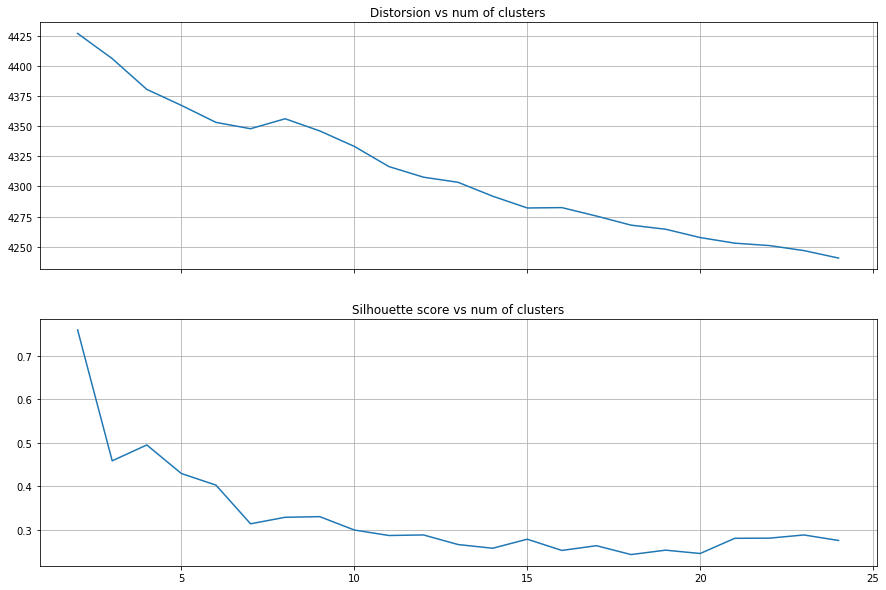

In [341]:
from sklearn.metrics import silhouette_score
from tqdm import tqdm_notebook
distorsions = []
sil_scores = []
k_max = 25
vectorizer = TfidfVectorizer(max_df=0.95,
                                     min_df=1, ngram_range=(1,2),
                                     stop_words=stop_words,
                                     strip_accents="unicode",
                                     use_idf=True, smooth_idf=True)

#vz = vectorizer.fit_transform(corpora)

for k in tqdm_notebook(range(2, k_max)):
    kmeans_model = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=1, random_state=42,  
                         init_size=500, verbose=True, max_iter=1000)
    #kmeans_model.fit(vz)
    
    km_transformer = Pipeline([('tfidf', vectorizer), 
                            ('km', kmeans_model),
                            ('norm', normalizer)])
    
    km = km_transformer.fit_transform(case_dict[:,1])
    
    # sil_score = silhouette_score(vz, kmeans_model.labels_)
    sil_score = silhouette_score(km, km_transformer.steps[1][1].labels_)
    sil_scores.append(sil_score)
    # distorsions.append(kmeans_model.inertia_)
    distorsions.append(km_transformer.steps[1][1].inertia_)

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 10))

ax1.plot(range(2, k_max), distorsions)
ax1.set_title('Distorsion vs num of clusters')
ax1.grid(True)

ax2.plot(range(2, k_max), sil_scores)
ax2.set_title('Silhouette score vs num of clusters')
ax2.grid(True)

In [136]:
def kmeans_cluster(corpora, n_clusters=4, ngrams=(1,2)):
    print(f"{len(corpora)} documents")
    
    print("Extracting features from the training dataset "
          "using a sparse vectorizer")
    t0 = time.time()
    
    vectorizer = TfidfVectorizer(max_df=0.95,
                                     min_df=1, ngram_range=ngrams,
                                     stop_words=stop_words,
                                     use_idf=True)
    km = MiniBatchKMeans(n_clusters=n_clusters, init='k-means++', n_init=100,
                             init_size=500, batch_size=1000)
    X = vectorizer.fit_transform(corpora)
    
    
    print(f"done in {(time.time() - t0)}")
    print("n_samples: %d, n_features: %d" % X.shape)
    print()
    
    
    print(f"Clustering sparse data with {km}")
    t0 = time.time()
    km.fit(X)
    print(f"done in {(time.time() - t0)}")
    print()
    
    
    print(f"Silhouette Coefficient: {silhouette_score(X, km.labels_)}") # sample size=5000
    
    print()
    print(f"Top terms per cluster:")
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    
    terms = vectorizer.get_feature_names()
    for i in range(n_clusters):
        print(f"Cluster {i}:")
        for ind in order_centroids[i, :10]:
            print(f'{terms[ind]}')
            print()       
    
    
    clusters = {}
    for i in range(n_clusters):
        clusters[i] = []
        for ind in order_centroids[i, :10]:
            clusters[i].append(terms[ind])
    clusters["labels"] = km.labels_
    clusters["vocab"] = vectorizer.vocabulary_
    clusters["matrix"] = X
    
    return clusters

def rolling_kmeans(binned_data):    # (binned_data, year_ranges)
    
    model_ranges = defaultdict(dict)
    
    for y in tqdm_notebook(binned_data.keys()): # keys must be year ranges
        model_ranges[y] = kmeans_cluster(binned_data[y][:,1], n_clusters=4, ngrams=(1,2))
                                                        # [:,1] needed only if binned_data is np.array. 
                                                        # use .append() instead of = if model_ranges is dict 
                                                        # as opposed to defaultdict
        print(f"Running cases from: {y}") 
        print()
    
    return model_ranges

In [85]:
clusters = kmeans_cluster(case_dict[:,1])

4579 documents
Extracting features from the training dataset using a sparse vectorizer
done in 62.50065517425537
n_samples: 4579, n_features: 4295792

Clustering sparse data with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=500, max_iter=100, max_no_improvement=10, n_clusters=4,
        n_init=100, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
done in 72.37593483924866

Silhouette Coefficient: 0.005784328546488373

Top terms per cluster:
Cluster 0:
public

power

school

property

city

congress

question

contract

constitution

new

Cluster 1:
jury

death

trial

juror

death penalty

penalty

defendant

murder

mitigate

capital

Cluster 2:
trial

counsel

criminal

defendant

appeal

evidence

search

conviction

jury

police

Cluster 3:
tax

property

taxation

corporation

business

income

value

commerce

assessment

stock



In [56]:
cluster["labels"]

array([4, 4, 4, ..., 1, 2, 4], dtype=int32)

In [224]:
corp['topics'] = cluster['labels']

In [225]:
top_cols = ['case_name', 'year', 'topics']
topic_df = corp[top_cols]

In [226]:
topic_df.head(10)

,case_name,year,topics
1523,Worthy v. Commissioners,1870.0,6
1789,Osborn v. Nicholson,1872.0,7
3851,Bradwell v. State,1873.0,6
725,Slaughter-House Cases,1873.0,7
250,Bartemeyer v. Iowa,1874.0,7
2508,Minor v. Happersett,1875.0,8
1045,Scholey v. Rew,1875.0,1
3904,Raymond v. Thomas,1876.0,6
4491,Walker v. Sauvinet,1876.0,4
422,United States v. REESE,1876.0,8


In [134]:
kmb = rolling_kmeans(binned_data) 

5 documents
Extracting features from the training dataset using a sparse vectorizer
done in 0.05699801445007324
n_samples: 5, n_features: 12713

Clustering sparse data with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=500, max_iter=100, max_no_improvement=10, n_clusters=4,
        n_init=100, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
done in 1.0403730869293213

Silhouette Coefficient: 0.04402855377011278

Top terms per cluster:
Cluster 0:
citizen

privilege

liquor

property

immunity

privilege immunity

iowa

slaughter

animal

power

Cluster 1:
jurisdiction

authority exercise

authority

treaty

dismiss

cause

validity

writ want

treaty congress

contra chief

Cluster 2:
contract

slave

warranty

warrant

covenant

loss

title

property

sale

seller

Cluster 3:
woman

citizen

illinois

admit

citizenship

privilege

admission

practice

privilege immunity

immunity

Running cases from: (1865, 1875)

18 

done in 2.1159260272979736
n_samples: 414, n_features: 252070

Clustering sparse data with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=500, max_iter=100, max_no_improvement=10, n_clusters=4,
        n_init=100, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
done in 4.69268012046814

Silhouette Coefficient: 0.00822695014339784

Top terms per cluster:
Cluster 0:
tax

property

taxation

business

assessment

corporation

value

board

commerce

kentucky

Cluster 1:
ordinance

city

street

water

power

grant

property

railway

contract

franchise

Cluster 2:
power

defendant

question

land

employer

contract

insurance

constitution

person

property

Cluster 3:
railroad

commission

rate

order

carrier

car

train

line

passenger

public

Running cases from: (1910, 1920)

418 documents
Extracting features from the training dataset using a sparse vectorizer
done in 2.0149130821228027
n_samples: 418, n_features: 

done in 3.6080892086029053
n_samples: 282, n_features: 491945

Clustering sparse data with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=500, max_iter=100, max_no_improvement=10, n_clusters=4,
        n_init=100, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
done in 13.847714185714722

Silhouette Coefficient: 0.009340983462969077

Top terms per cluster:
Cluster 0:
tax

congress

apportionment

power

property

new

religious

school

government

constitutional

Cluster 1:
restaurant

ordinance

city

negro

trespass

public

facility

police

manager

conviction

Cluster 2:
communist

communist party

committee

organization

party

question

member

association

membership

government

Cluster 3:
trial

jury

confession

counsel

defendant

question

judge

grand

grand jury

evidence

Running cases from: (1955, 1965)

405 documents
Extracting features from the training dataset using a sparse vectorizer
done in 4.90

Cluster 0:
tribe

tribal

punitive damage

punitive

jurisdiction

damage

martinez

police

indian

award

Cluster 1:
jury

defendant

trial

death

offense

evidence

criminal

crime

judge

prison

Cluster 2:
voting

plan

preclearance

shaw

minority

racial

race

gerrymander

appellees

redistricting

Cluster 3:
congress

school

public

speech

government

student

tax

program

religious

power

Running cases from: (1995, 2005)

181 documents
Extracting features from the training dataset using a sparse vectorizer
done in 4.335085153579712
n_samples: 181, n_features: 624145

Clustering sparse data with MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=500, max_iter=100, max_no_improvement=10, n_clusters=4,
        n_init=100, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)
done in 18.411808013916016

Silhouette Coefficient: 0.013719226291110213

Top terms per cluster:
Cluster 0:
jury

defendant

trial

death

eviden

In [133]:
kmb[(1865, 1875)].keys()

dict_keys([0, 1, 2, 3, 'labels', 'vocabulary'])

In [217]:
lsa

defaultdict(dict,
            {(1860,
              1877): {'terms': ['perform',
               'qualify',
               'inspector',
               'election',
               'liquor',
               'offer',
               'officer',
               'person officer',
               'prerequisite',
               'vote'], 'weights': [0.09793710336955118,
               0.09843928590554911,
               0.09873165484423761,
               0.10615128143217127,
               0.11025570184951902,
               0.1303211755261476,
               0.13424204102282425,
               0.13575602541082674,
               0.1789511244051807,
               0.2249122887054151], 'matrix': array([[ 0.13367538,  0.52185652, -0.07278129,  0.69141446,  0.0859811 ,
                       0.4017047 , -0.23701665, -0.01627426,  0.02496346,  0.02485034,
                      -0.00192882],
                     [ 0.31030303,  0.3723568 , -0.22997015, -0.44727989,  0.09908121,
                      -0.12

### get info to plot the topics for clusters

In [88]:
print(f"lsa: {lsa[(1865, 1875)].keys()}")
print("\n")
print(f"kmeans: {kmb[(1865, 1875)].keys()}")

lsa: dict_keys(['terms', 'weights', 'matrix', 'feat_names', 'vocab'])


kmeans: dict_keys([0, 1, 2, 3, 'labels', 'vocabulary'])


In [79]:
# extract the frequency count for the top terms of the topic words 

# from the vocab within the vectorizer, for LSA:
print(lsa[(1865, 1875)]["vocab"].get("louisiana"))

#...and for kmeans:
print(kmb[(1865, 1875)]["vocabulary"].get("louisiana"))

7140
7133


In [326]:
lsa[(1865, 1875)]["vocab"].get("prerequisite")

15492

In [83]:
#for k in model_ranges.keys():
#    print(sorted(model_ranges[k][0][0])) #topic 0

#for k in lsa.keys():
    #if "louisiana" in lsa[k]['terms']:
    #    print(f"'louisiana' in range {k}, topic {lsa[k]}: \n{lsa[k]['terms']}\n\n") 
    #for term in model_ranges[k][0][j]:
    #    if term in (sorted(model_ranges[k][0][j])):
    #        print(f"'{term}' in range {k}, topic {j}: \n{model_ranges[k][0][j]}\n\n")

In [106]:
def get_freq_dict(lsa, exclusions):
    # matrix indices should equal case_dict indices for case names... 
    top_terms = defaultdict(int)
    keys = list(set(lsa.keys()) - set(exclusions))
    for k in keys:
        for term in lsa[k]["terms"]:
            top_terms[term] = lsa["vocab"].get(term)
    return top_terms

lsa_exclusions = [0, 1, 'vocab']

In [107]:
lsat = get_freq_dict(lsa, lsa_exclusions)
# kmt = get_freq_dict(kmb, kmeans_exclusions)

In [130]:
top_terms = defaultdict(int)
for k in keys:
        terms = [term.split() for term in lsa[k]["terms"]]
        terms = [t for l in terms for t in l]
        print(terms)
        for term in terms:
            print(term)
            print(lsa["vocab"].get(term))
            top_terms[term] = lsa["vocab"].get(term)

[['wolf'], ['fourth', 'amendment'], ['fifth', 'amendment'], ['self', 'incrimination'], ['incrimination'], ['sunday'], ['privilege'], ['religious'], ['search'], ['prosecution']]
['wolf']


TypeError: unhashable type: 'list'

In [118]:
top_terms

defaultdict(int,
            {'wolf': None,
             'fourth amendment': None,
             'fifth amendment': None,
             'self incrimination': None,
             'incrimination': None,
             'sunday': None,
             'privilege': None,
             'religious': None,
             'search': None,
             'prosecution': None,
             'public school': None,
             'board': None,
             'language school': None,
             'pupil': None,
             'teach': None,
             'foreign language': None,
             'taught': None,
             'language': None,
             'child': None,
             'school': None,
             'minor': None,
             'hospital': None,
             'patient': None,
             'fetus': None,
             'roe': None,
             'medical': None,
             'woman': None,
             'pregnancy': None,
             'physician': None,
             'abortion': None,
             'assessment': None,
   

In [ ]:
from inspect import Parameter
class Rolling_Topic:    
    
    def __init__(self, function, binned_data, **kwargs):
        self.model_ranges = defaultdict(dict)
        self.binned_data = binned_data
        self.function = function
        for k in kwargs.keys():
            if k in get_kwargs(self.function):
                # self.__setattr__(k, kwargs[k]) set FUNCTION attr
                
    def get_kwargs(function):
        """Get names of callable arguments.

        Special arguments (like ``*args`` and ``**kwargs``) are not included into
        output.

        If required_only is True, optional arguments (with default values)
        are not included into output.
        """
        sig = get_signature(function)
        function_args = list(six.iterkeys(sig.parameters))
        for param_name, p in six.iteritems(sig.parameters):
        if (p.kind in (Parameter.VAR_POSITIONAL, Parameter.VAR_KEYWORD) 
            or (required_only and p.default is not Parameter.empty)):
            function_args.remove(param_name)
        
        return function_args 
    
    def roll(self.binned_data):
        for y in tqdm_notebook(binned_data.keys()):
            model_ranges[y] = self.function(binned_data[y][:,1]) # [:,1] needed only if binned_data is np.array. 
                                                           # use .append() instead of = if model_ranges is dict 
                                                           # as opposed to defaultdict
        print(f"Running cases from: {y}") 
        
    return model_ranges    

In [348]:
# for k in lsa.keys():
#     print(lsa[k]["terms"])

for k in list(set(lsa.keys()) - set([0, 1, 'vocab'])):
    try:
        print(lsa[k]["terms"])
    except:
        print(f"{k} has no terms")

['successive prosecution', 'hutchinson', 'prison', 'double', 'double jeopardy', 'jeopardy', 'sovereign', 'juror', 'offence', 'gamble']
['commerce', 'writ habeas', 'writ', 'ordinance', 'assessment', 'commission', 'corpus', 'habeas corpus', 'habeas', 'rate']
['ballot', 'offense', 'child', 'candidate', 'jeopardy clause', 'election', 'double', 'double jeopardy', 'tax', 'jeopardy']
['negro', 'oklahoma', 'commission', 'child', 'public school', 'religious', 'confession', 'education', 'insurance', 'school']
['perform', 'qualify', 'inspector', 'election', 'liquor', 'offer', 'officer', 'person officer', 'prerequisite', 'vote']
['peremptory challenge', 'immunity', 'peremptory', 'jeopardy clause', 'search', 'offense', 'school', 'double', 'double jeopardy', 'jeopardy']
['school', 'search', 'citizen', 'congress', 'color', 'citizenship', 'alien', 'race', 'negro', 'restaurant']
['decree', 'sup', 'interstate commerce', 'liquor', 'interstate', 'ordinance', 'commerce', 'oil', 'gasoline', 'tax']
['dire', 

In [277]:
# get the years for plotly go graph
plotyears = sorted(list(set([y for k in list(binned_data.keys()) for y in k])))

In [318]:
# the indices in the tfidf matrix are the same as the case_dict indices
lsa[(1865, 1875)]["vocab"].get("")

{'terms': ['perform',
  'qualify',
  'inspector',
  'election',
  'liquor',
  'offer',
  'officer',
  'person officer',
  'prerequisite',
  'vote'],
 'weights': [0.09793710336955118,
  0.09843928590554911,
  0.09873165484423761,
  0.10615128143217127,
  0.11025570184951902,
  0.1303211755261476,
  0.13424204102282425,
  0.13575602541082674,
  0.1789511244051807,
  0.2249122887054151],
 'matrix': array([[ 0.13367538,  0.52185652, -0.07278129,  0.69141446,  0.0859811 ,
          0.4017047 , -0.23701665, -0.01627426,  0.02496346,  0.02485034,
         -0.00192882],
        [ 0.31030303,  0.3723568 , -0.22997015, -0.44727989,  0.09908121,
         -0.12334071, -0.52355296, -0.45983568, -0.00465482,  0.01443524,
         -0.03605909],
        [ 0.49264563, -0.37313293, -0.21893821,  0.05263512,  0.0741469 ,
          0.35610365,  0.22779888, -0.37610839, -0.44410257,  0.2006412 ,
         -0.06500997],
        [ 0.74580332, -0.16115907, -0.16710534, -0.01691251,  0.06855508,
          0.053

### Plotly

In [280]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.figure(data=go.Scatter[x=yearstoplot, mode="markers", color="",
                     hover_name="case_name", text="case_name",
                     animation_frame="year", size="citation_count"])
fig.show()

SyntaxError: invalid syntax (<ipython-input-280-00ac794323e9>, line 4)

In [213]:
import spacy
from spacy.tokens import Token
nlp = spacy.load('en_core_web_sm')

doc = nlp(str(binned_data[(1960, 1970)][:,1][311]))
print(set([token.text for token in doc if token.ent_type_ == "GPE"]))

{'california'}
